In [ ]:
!unzip data.zip

In [18]:
# ## 1. Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# 시각화 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')
# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

In [19]:
# ## 2. Data Loading and Initial Exploration
try:
    # 데이터 파일 로드
    train_df = pd.read_csv("/content/data/train.csv")
    test_df = pd.read_csv("/content/data/test.csv")
    print("Train and Test datasets loaded successfully.")
    print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")
except FileNotFoundError:
    print("Error: 'train.csv' or 'test.csv' not found. Please check file paths.")
    train_df = pd.DataFrame()

if not train_df.empty:
    print("\nTrain data head:")
    print(train_df.head())

    print("\nCheck for missing values in training data:")
    print(train_df.isnull().sum())

Train and Test datasets loaded successfully.
Train shape: (1459, 11), Test shape: (715, 10)

Train data head:
   id  hour  hour_bef_temperature  hour_bef_precipitation  hour_bef_windspeed  \
0   3    20                  16.3                     1.0                 1.5   
1   6    13                  20.1                     0.0                 1.4   
2   7     6                  13.9                     0.0                 0.7   
3   8    23                   8.1                     0.0                 2.7   
4   9    18                  29.5                     0.0                 4.8   

   hour_bef_humidity  hour_bef_visibility  hour_bef_ozone  hour_bef_pm10  \
0               89.0                576.0           0.027           76.0   
1               48.0                916.0           0.042           73.0   
2               79.0               1382.0           0.033           32.0   
3               54.0                946.0           0.040           75.0   
4                7.0   


--- Handling Missing Values ---
Filling missing values in 'hour_bef_temperature' with mean: 16.72
Filling missing values in 'hour_bef_precipitation' with mean: 0.03
Filling missing values in 'hour_bef_windspeed' with mean: 2.48
Filling missing values in 'hour_bef_humidity' with mean: 52.23
Filling missing values in 'hour_bef_visibility' with mean: 1405.22
Filling missing values in 'hour_bef_ozone' with mean: 0.04
Filling missing values in 'hour_bef_pm10' with mean: 57.17
Filling missing values in 'hour_bef_pm2.5' with mean: 30.33

Missing values AFTER handling in train_df: 0
Missing values AFTER handling in test_df: 0


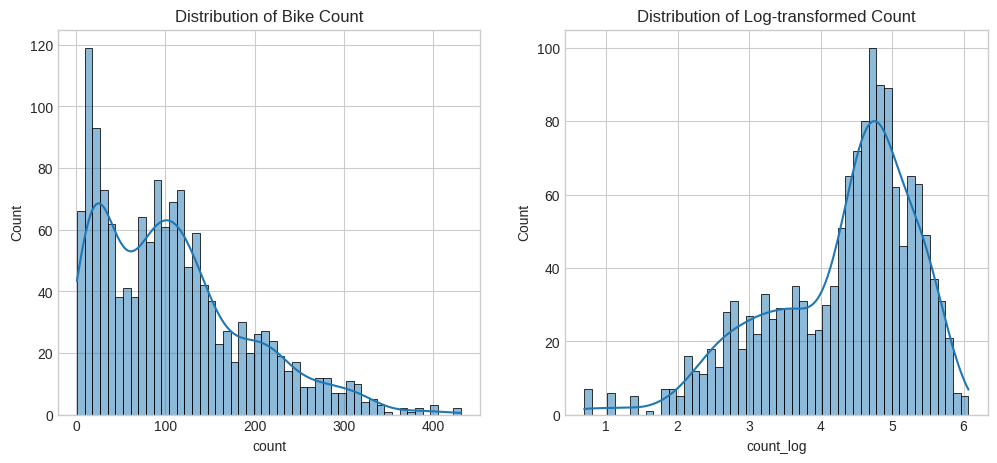

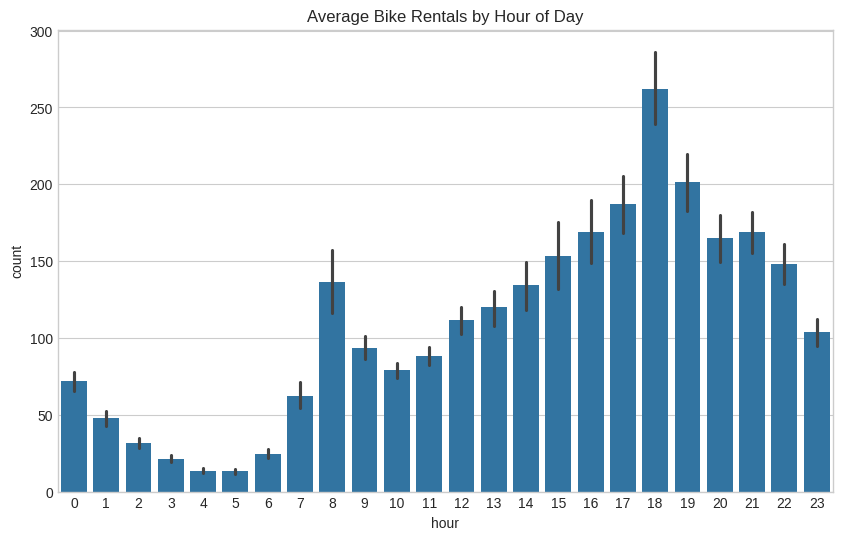

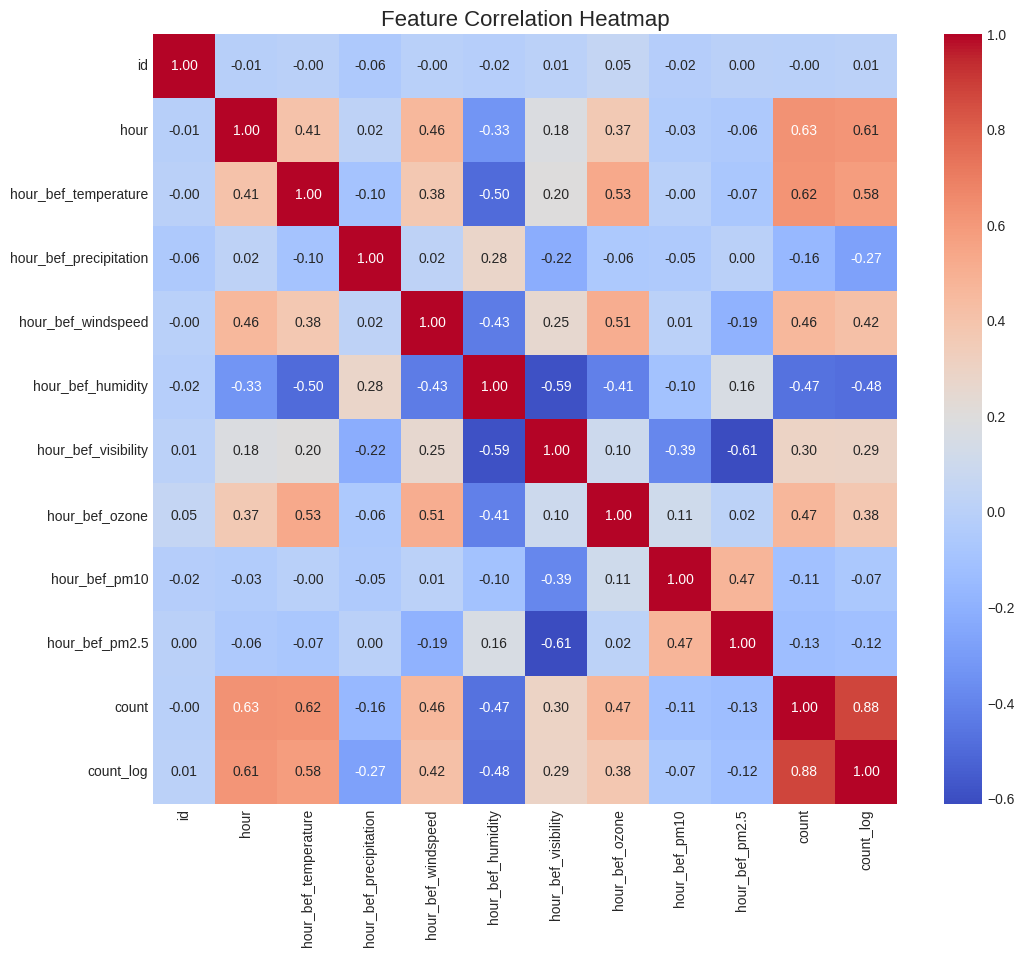

In [20]:
# ## 3. Data Preprocessing and EDA
if not train_df.empty:
    # ### 3.1. Missing Value Imputation (결측치 처리)
    # 결측치가 있는 모든 컬럼을 찾아 평균값으로 채웁니다.
    print("\n--- Handling Missing Values ---")
    for col in train_df.columns:
        if train_df[col].isnull().any():
            # 훈련 데이터셋의 평균값 계산
            mean_value = train_df[col].mean()
            print(f"Filling missing values in '{col}' with mean: {mean_value:.2f}")

            # 훈련 데이터셋과 테스트 데이터셋의 결측치를 동일한 평균값으로 채움
            train_df[col].fillna(mean_value, inplace=True)
            if col in test_df.columns:
                test_df[col].fillna(mean_value, inplace=True)

    print("\nMissing values AFTER handling in train_df:", train_df.isnull().sum().sum())
    print("Missing values AFTER handling in test_df:", test_df.isnull().sum().sum())


    # ### 3.2. Target Variable Analysis (count)
    # 대여량(count)의 분포 확인 및 로그 변환
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(train_df['count'], ax=axes[0], kde=True, bins=50)
    axes[0].set_title('Distribution of Bike Count')
    # 로그 변환 적용
    train_df['count_log'] = np.log1p(train_df['count'])
    sns.histplot(train_df['count_log'], ax=axes[1], kde=True, bins=50)
    axes[1].set_title('Distribution of Log-transformed Count')
    plt.show()

    # ### 3.3. EDA on Features
    # 시간대별 평균 대여량
    plt.figure(figsize=(10, 6))
    sns.barplot(data=train_df, x='hour', y='count')
    plt.title('Average Bike Rentals by Hour of Day')
    plt.show()

    # 수치형 변수 간 상관관계 히트맵
    plt.figure(figsize=(12, 10))
    corr = train_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Feature Correlation Heatmap', fontsize=16)
    plt.show()

In [22]:
# ## 4. Model Training and Comparison
if not train_df.empty:
    # 훈련에 불필요한 'id'와 원본 'count' 컬럼 제거
    X = train_df.drop(['id', 'count', 'count_log'], axis=1)
    y_log = train_df['count_log']

    # 훈련/검증 데이터 분할
    X_train, X_val, y_train_log, y_val_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

    print(f"\nTraining data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")

    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
        "XGBoost": XGBRegressor(random_state=42, n_jobs=-1),
        "LightGBM": LGBMRegressor(random_state=42, n_jobs=-1)
    }

    results = {}

    # RMSE (Root Mean Squared Error) 계산 함수
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    for name, model in models.items():
        print(f"\n--- Training {name} ---")
        model.fit(X_train, y_train_log)
        y_pred_log = model.predict(X_val)

        score_rmse = rmse(np.expm1(y_val_log), np.expm1(y_pred_log)) # 원래 스케일로 변환 후 RMSE 계산

        results[name] = {'RMSE': score_rmse}
        print(f"RMSE on validation data: {score_rmse:.4f}")

    results_df = pd.DataFrame(results).T
    print("\n--- Model Performance Comparison ---")
    print(results_df.sort_values(by='RMSE', ascending=True))


Training data shape: (1167, 9)
Validation data shape: (292, 9)

--- Training Linear Regression ---
RMSE on validation data: 53.2771

--- Training Random Forest ---
RMSE on validation data: 39.8673

--- Training XGBoost ---
RMSE on validation data: 39.9499

--- Training LightGBM ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 1167, number of used features: 9
[LightGBM] [Info] Start training from score 4.321575
RMSE on validation data: 39.2020

--- Model Performance Comparison ---
                        RMSE
LightGBM           39.202032
Random Forest      39.867278
XGBoost            39.949908
Linear Regression  53.277142



--- Analysis and Prediction using Best Model: LightGBM ---


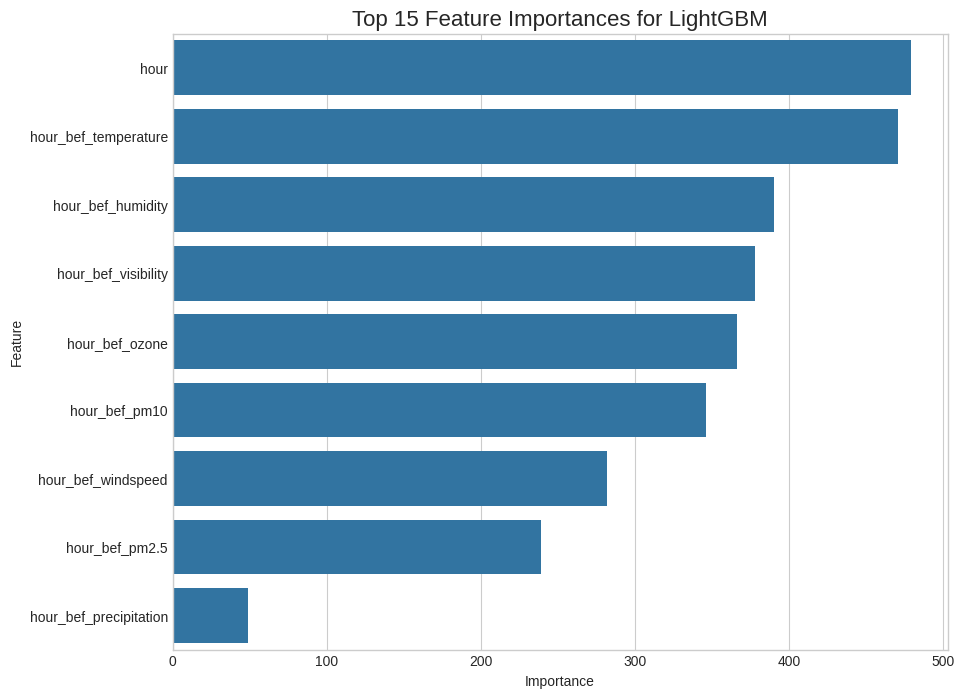


Predicting on test data...

'submission.csv' file has been created successfully.
Submission file head:
   id       count
0   0   86.763933
1   1  204.522746
2   2   14.018963
3   4   31.447027
4   5   12.457446


In [24]:
# ## 5. Results Analysis and Submission File Generation
if not train_df.empty:
    best_model_name = results_df['RMSE'].idxmin()
    best_model = models[best_model_name]
    print(f"\n--- Analysis and Prediction using Best Model: {best_model_name} ---")

    # 특성 중요도 분석 (Tree-based 모델인 경우)
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
        plt.title(f'Top 15 Feature Importances for {best_model_name}', fontsize=16)
        plt.show()

    # 테스트 데이터에 대한 최종 예측
    print("\nPredicting on test data...")
    X_test = test_df.drop('id', axis=1)
    final_predictions_log = best_model.predict(X_test)

    # 예측값을 원래 스케일로 되돌리기 (로그 역변환)
    final_predictions = np.expm1(final_predictions_log)

    # 예측값이 음수가 되지 않도록 처리
    final_predictions[final_predictions < 0] = 0

    # 제출 파일 생성
    submission_df = pd.DataFrame()
    submission_df['id'] = test_df['id']
    submission_df['count'] = final_predictions

    submission_df.to_csv('submission.csv', index=False)
    print("\n'submission.csv' file has been created successfully.")
    print("Submission file head:")
    print(submission_df.head())